In [1]:
# Importanweisungen

import sys
import numpy as np
import statistics as stat
import scipy as sci
import scipy.fftpack
#import sympy as sym
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import matplotlib.axes as axes
from matplotlib import colors as mcolors
import math
from scipy import optimize
import uncertainties as unc
import uncertainties.unumpy as unp
import uncertainties.umath as umath
unv=unp.nominal_values
usd=unp.std_devs

import os

# mathe Funktionen
def find_maxima(xarray, yarray, eps=0.):
    #find the positions of the local maxima of yarry array
    #every value with 2 neighbours of lower values gets counted
    #except if it's less than eps away in yarray from the last maximum
    #never uses the outermost values
    #assumes sorted xarray
    result = []
    lastRel = False # true if last value was higher than second to last value
    for i in range(len(xarray)-1):
        if(yarray[i]>=yarray[i+1]):
            if(lastRel):
                if(result==[] or xarray[i]>xarray[result[-1]]+eps): result.append(i)
            lastRel = False
        else: lastRel = True
    return np.array(result)
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
def find_nearest(array, value):
    array[find_nearest_index(array,value)]
def normalize(ydata):
    return (ydata-np.amin(ydata))/(np.amax(ydata)-np.amin(ydata))
def mean(n):
    # find the mean value and add uncertainties
    k = np.mean(n)
    err = stat.variance(unv(n))
    return unc.ufloat(unv(k), math.sqrt(usd(k)**2 + err))

def fft(y):
    N = len(y)
    fft = scipy.fftpack.fft(y)
    return 2 * abs(fft[:N//2]) / N

    # allgemeine Fitfunktionen

def linear(x,m): # lineare Funktion mit f(x) = m * x
    return(m*x)

def gerade(x, m, b): # gerade mit = f(x) = m * x + b
    return (m*x + b)

def cyclic(x, a, f, phi):
    return a * np.sin(x * f - phi)

def cyclicOff(x, a, f, phi, offset):
    return cyclic(x, a, f, phi) + offset

def gauss(x, x0, A, d, y0):
    return A * np.exp(-(x - x0)**2 / 2 / d**2) + y0

def exponential(x, c, y0):
    return np.exp(c * x) * y0

def custom(x,n):
    m = x
    l = 650.4*10**-9#unc.ufloat(630,10)*10**-9
    #l =unp.uarray([630],[10])*10**-9
    #t = unp.uarray([5],[0.1])*10**-3
    t = 5.05*10**-3#unc.ufloat(5,0.1)*10**-3
    return (n*m*l+m*m*l*l/(4*t))/(m*l+2*t*(n-1))

# fittet ein dataset mit gegebenen x und y werten, eine funktion und ggf. anfangswerten und y-Fehler
# gibt die passenden parameter der funktion, sowie dessen unsicherheiten zurueck
#
# https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i#
# Updated on 4/6/2016
# User: https://stackoverflow.com/users/1476240/pedro-m-duarte
def fit_curvefit(datax, datay, function, p0=None, yerr=None, **kwargs):
    pfit, pcov = \
         optimize.curve_fit(function,datax,datay,p0=p0,\
                            sigma=yerr, epsfcn=0.0001, **kwargs)
    error = []
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return pfit_curvefit, perr_curvefit

# fittet ein dataset mit gegebenen x und y werten, eine funktion und ggf. anfangswerten und y-Fehler
# gibt die passenden parameter der funktion, sowie dessen unsicherheiten zurueck
#
# https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i#
# Updated on 4/6/2016
# User: https://stackoverflow.com/users/1476240/pedro-m-duarte
def fit_curvefit2(datax, datay, function, p0=None, yerr=None, **kwargs):
    pfit, pcov = \
         optimize.curve_fit(function,datax,datay,p0=p0,\
                            sigma=yerr, epsfcn=0.0001, **kwargs)
    error = []
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return unp.uarray(pfit_curvefit, perr_curvefit)
# usage zB:
# pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [1, 0])
# fuer eine gerade mit anfangswerten m = 1, b = 0


# Konstanten fuer einheitliche Darstellung

fig_size = (10, 6)
fig_legendsize = 22
fig_labelsize = 23
fig_ticksize = 23
matplotlib.rcParams.update({'font.size': fig_labelsize})

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
#colors


# weitere Werte, Konstanten
# Werte von https://physics.nist.gov/cuu/Constants/index.html[0]

c = 299792458 # m/s
k_B = unc.ufloat_fromstr("1.38064852(79)e-23") # J K-1 [0]
h = unc.ufloat_fromstr("4.135667662(25)e-15") # eV s [0]
r_e = unc.ufloat_fromstr("2.8179403227(19)e-15") # m [0]
R = unc.ufloat_fromstr("8.3144598(48)") # J mol-1 K-1 [0]
K = 273.15 # kelvin
g = 9.81 # m/s^2
rad = 360 / 2 / math.pi
grad = 1/rad

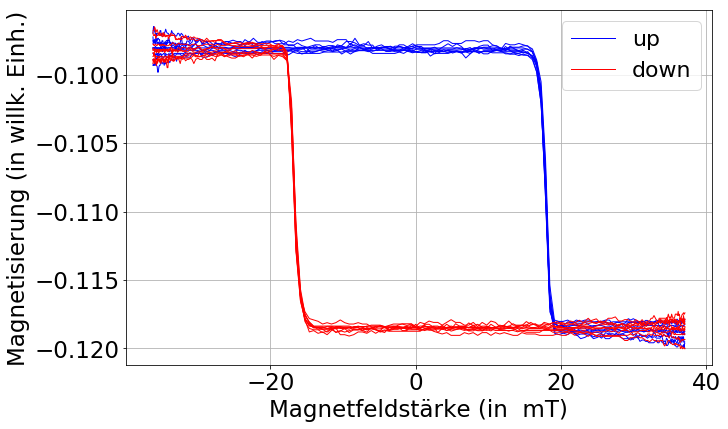

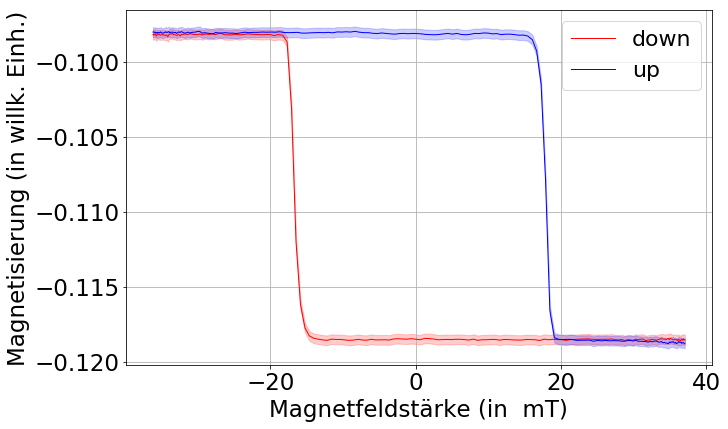

In [12]:
# plots
pathto = "../raw/2020-08-12-10-45-17_CoPt/"
#pathto = "../raw/2020-08-13-08-31-40_CrO2/"
files = [txt_file for txt_file in os.listdir(pathto) if "0" in txt_file]
ydata_up = []
ydata_down = []
dset = False
uset = False
for file in files:
    data = np.loadtxt(pathto+file, unpack=True, skiprows = 2, delimiter = ",") #delimiter=","
    if("d" in file):
        if(not dset):
            xdata_down = unp.uarray(data[1], 0.1) #error=0.1 ; Einheit: mT? (vlt. muT?)
            dset = True
        ydata_down.append(unp.uarray(data[2], 0.001)) #error=0.001/0.0004 ; Einheit: a.u.
    else:
        if(not uset):
            xdata_up = unp.uarray(data[1], 0.1) #error=0.1 ; Einheit: mT? (vlt. muT?)
            uset = True
        ydata_up.append(unp.uarray(data[2], 0.001)) #error=0.001/0.0004 ; Einheit: a.u.

#linearer thermischer Drift pro Messung und pro Tesla
drift = 0 #(xdata_down -min(xdata_down)) * 6.9e-6
ydata_avg0_down = unp.uarray(np.zeros(len(xdata_down)), 0)
ydata_avg0_up = unp.uarray(np.zeros(len(xdata_down)), 0)
fix_down_y = sum(ydata_down[0])/len(ydata_down[0])
fix_up_y = fix_down_y
fig=plt.figure(figsize=fig_size)
for ydata in ydata_down[:]:
    miny = sum(ydata)/len(ydata)
    ydata = ydata + fix_down_y - miny + drift
    plt.plot(unv(xdata_down), unv(ydata), label='up',linewidth='1', color="blue") # swapped
    ydata_avg0_down += ydata
ydata_avg0_down= ydata_avg0_down/len(ydata_down)
for ydata in ydata_up[:]:
    miny = sum(ydata)/len(ydata)
    #ydata = ydata + fix_up_y - miny + drift + 0.0001
    ydata = ydata + fix_up_y - miny + drift - 0.0059
    plt.plot(unv(xdata_up), unv(ydata), label='down',linewidth='1', color="red") # swapped
    ydata_avg0_up += ydata
ydata_avg0_up= ydata_avg0_up/len(ydata_up)
plt.grid()
plt.tick_params(labelsize=fig_ticksize)
plt.legend(fontsize = fig_legendsize)
plt.xlabel(r'Magnetfeldstärke (in  mT)', size = fig_labelsize)
plt.ylabel(r'Magnetisierung (in willk. Einh.)', size = fig_labelsize)
plt.tight_layout(pad=0.3)
plt.savefig("../img/all_magn.png")
plt.show()

fig=plt.figure(figsize=fig_size)
plt.plot(unv(xdata_up), unv(ydata_avg0_up), label='down',linewidth='1', color = "red") #swapped
plt.plot(unv(xdata_down), unv(ydata_avg0_down), label='up',linewidth='1', color = "blue") # swapped
plt.fill_between(unv(xdata_up), unv(ydata_avg0_up) - usd(ydata_avg0_up),
                 unv(ydata_avg0_up) + usd(ydata_avg0_up), facecolor='red',
                 alpha=0.2, color="red")
plt.fill_between(unv(xdata_down), unv(ydata_avg0_down) - usd(ydata_avg0_down),
                 unv(ydata_avg0_down) + usd(ydata_avg0_down), facecolor='blue',
                 alpha=0.2, color="blue")
#plt.plot(unv(xdata_up), unv(avg_pre_up), label='pre up',linewidth='1')
#plt.plot(unv(xdata_down), unv(avg_pre_down), label='pre down',linewidth='1')
plt.grid()
plt.tick_params(labelsize=fig_ticksize)
plt.legend(fontsize = fig_legendsize)
plt.xlabel(r'Magnetfeldstärke (in  mT)', size = fig_labelsize)
plt.ylabel(r'Magnetisierung (in willk. Einh.)', size = fig_labelsize)
plt.tight_layout(pad=0.3)
plt.savefig("../img/avg_magn_man.png")
plt.show()